In [5]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATv2Conv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

In [6]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x

In [7]:
input_size = 7
hidden_size = 128
output_size = 15

cols = ["ICFC", "MPFL", "GMFIL", "CFCL", "JFL", "NFS", "SFCL", "PROFL", "MFIL", "BFC", "PFL", "GUFL", "RLFL"]
scaler = joblib.load("../scalers/fin.pkl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("../models/gcn_inv.pth", map_location=device, weights_only=True))
model = model.to(device)
model.eval()

graphs = torch.load("../graphs/test_graphs/fin_test.pt", weights_only=False)
loader = DataLoader(graphs, batch_size=32, shuffle=False)

In [8]:
def split_predictions(predictions, cols):
    predictions = np.array(predictions)

    dataframes = []

    for i in range(len(cols)):
        df = pd.DataFrame({'Close': predictions[:, i]})

        for j in range(6):
            df[f'col_{j+1}'] = 0

        dataframes.append(df)

    return dataframes

def generate_predictions(graphs):
    predictions = []
    ground_truth = []
    for batch in graphs:
        batch = batch.to(device)
        with torch.no_grad():
            output = model(batch.x, batch.edge_index, batch.batch)
            output = output.view(-1)
            predictions.append(output.cpu().numpy())
            ground_truth.append(batch.y.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)

    # Reshape to match the original feature dimensions
    predictions = predictions.reshape(-1, output_size)
    ground_truth = ground_truth.reshape(-1, output_size)

    predictions = split_predictions(predictions, cols)
    ground_truth = split_predictions(ground_truth, cols)

    og_cols = predictions[0].columns
    # Inverse transform to the original scale
    predictions_original = [scaler.inverse_transform(prediction) for prediction in predictions]
    ground_truth_original = [scaler.inverse_transform(truth) for truth in ground_truth]

    predictions_original = [pd.DataFrame(df, columns=og_cols) for df in predictions_original]
    ground_truth_original = [pd.DataFrame(df, columns=og_cols) for df in ground_truth_original]

    # Add a 'published_date' column for plotting
    for df in predictions_original:
        df['published_date'] = np.arange(len(df))

    for df in ground_truth_original:
        df['published_date'] = np.arange(len(df))

    return predictions_original, ground_truth_original

In [9]:
test_predictions_df, test_ground_truth_df = generate_predictions(loader)

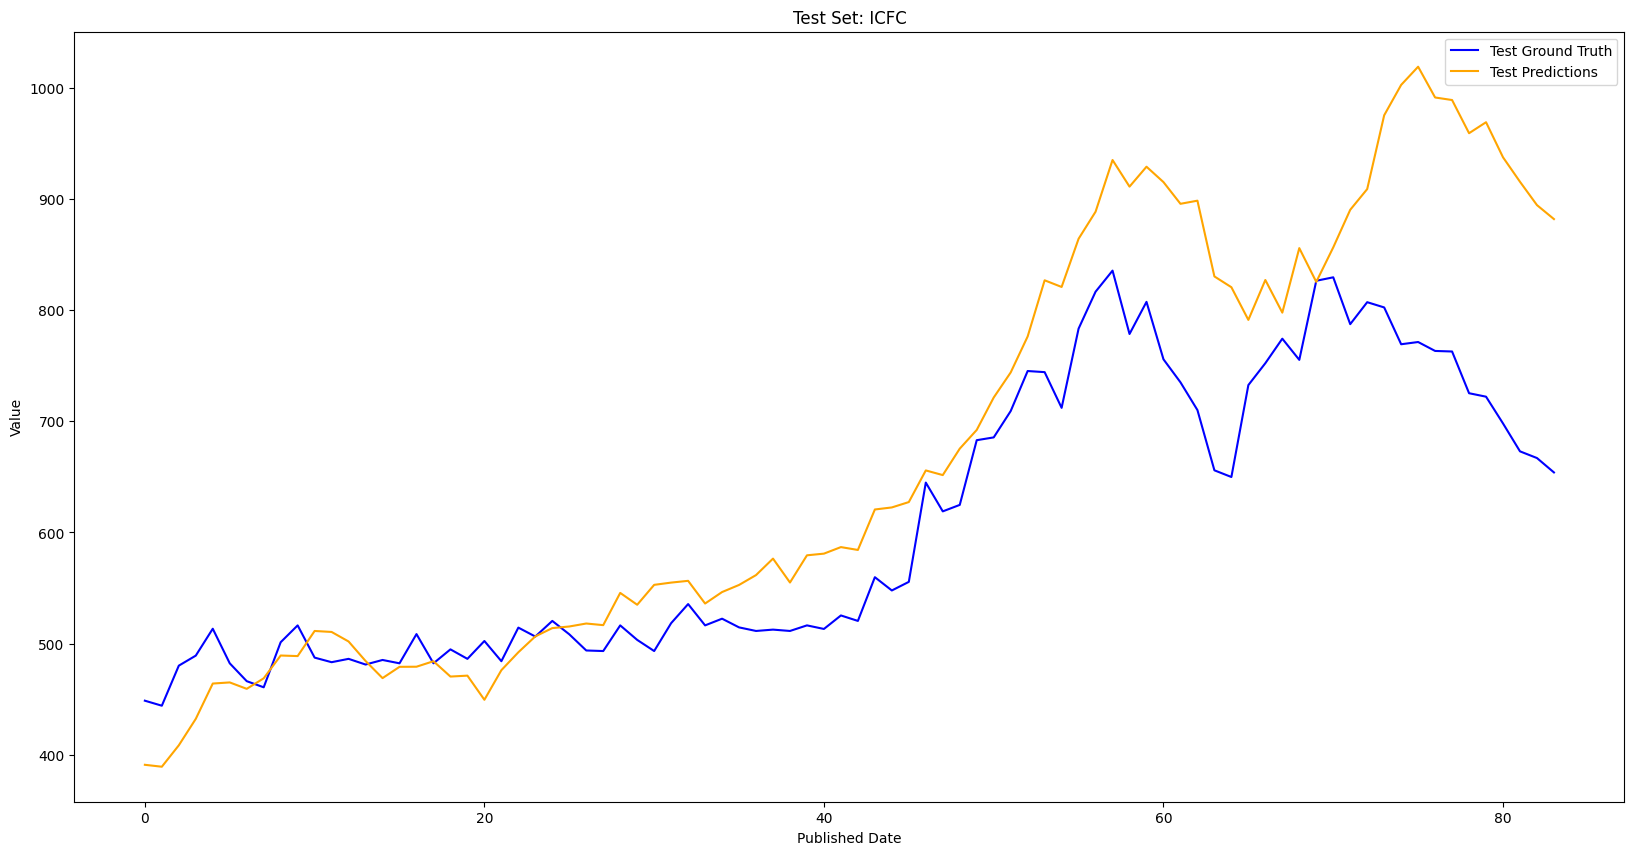

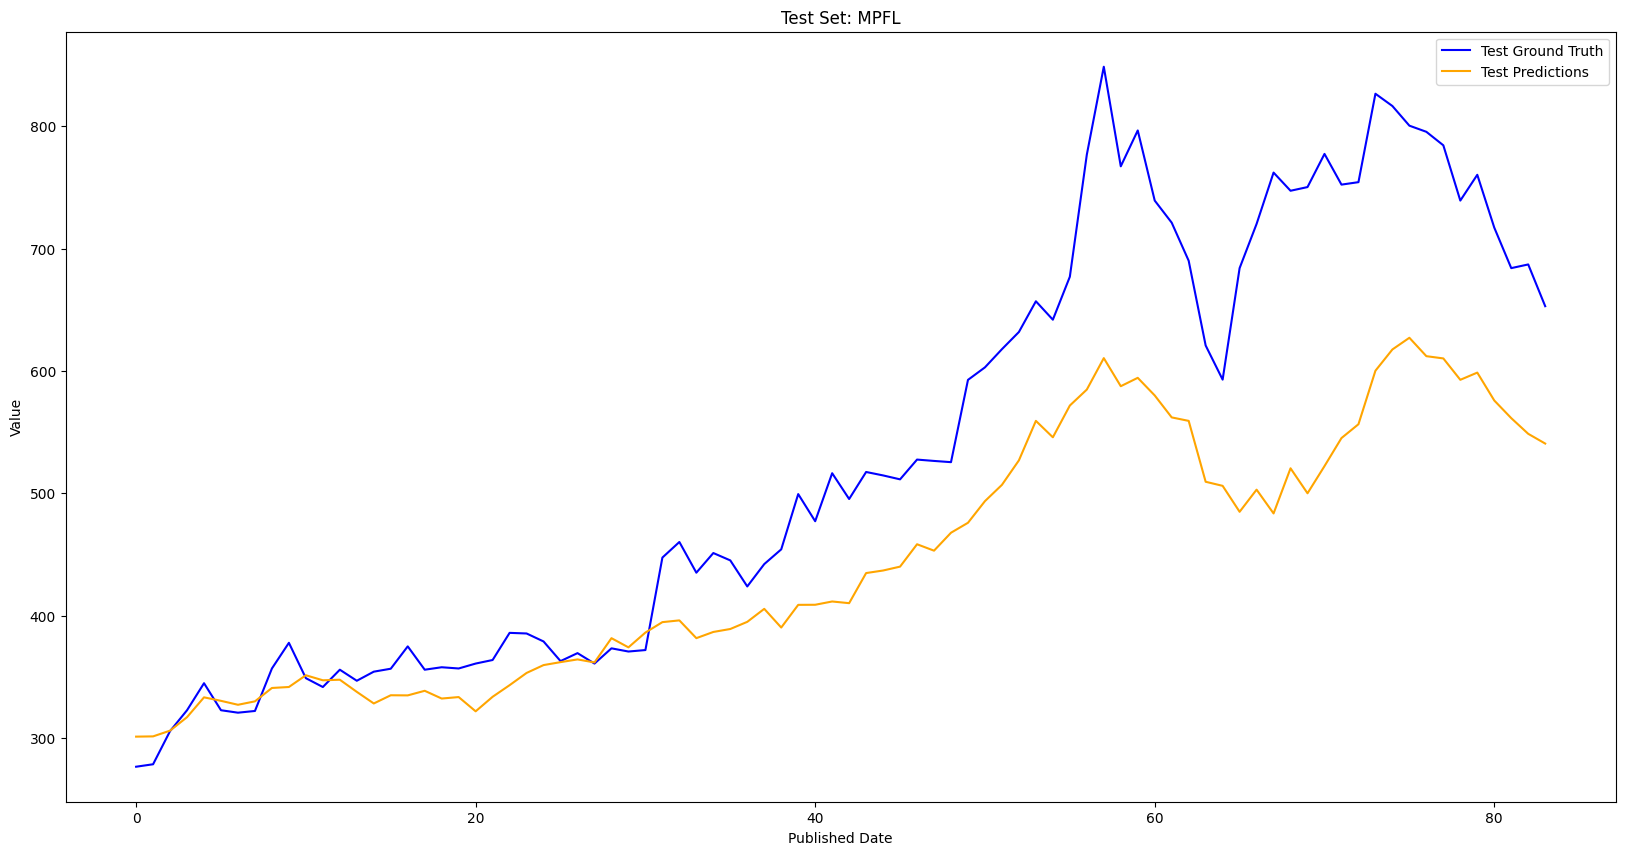

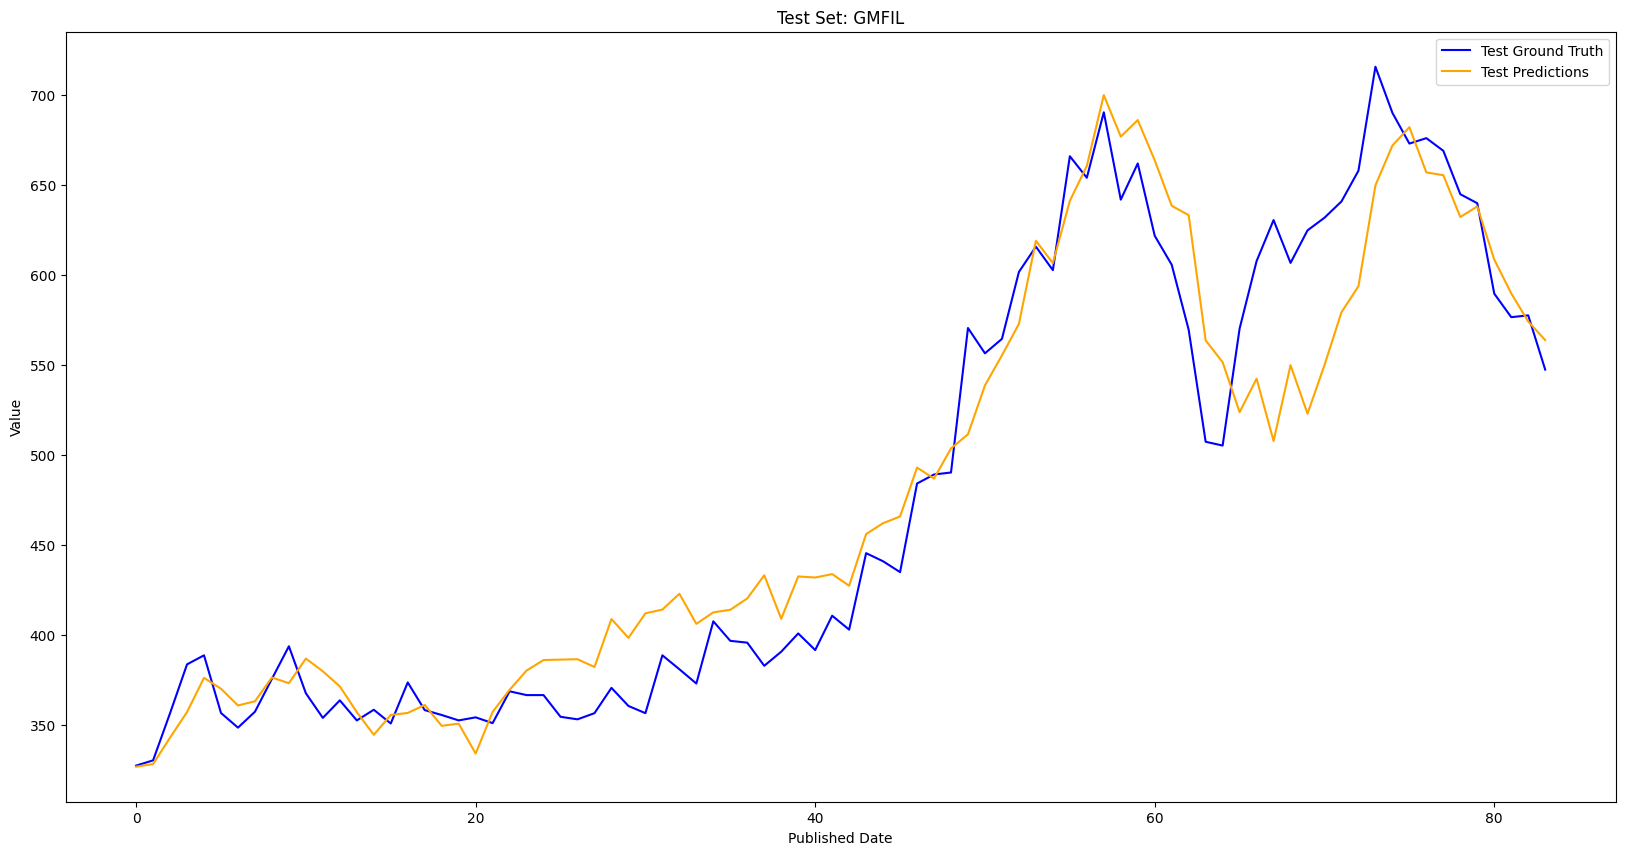

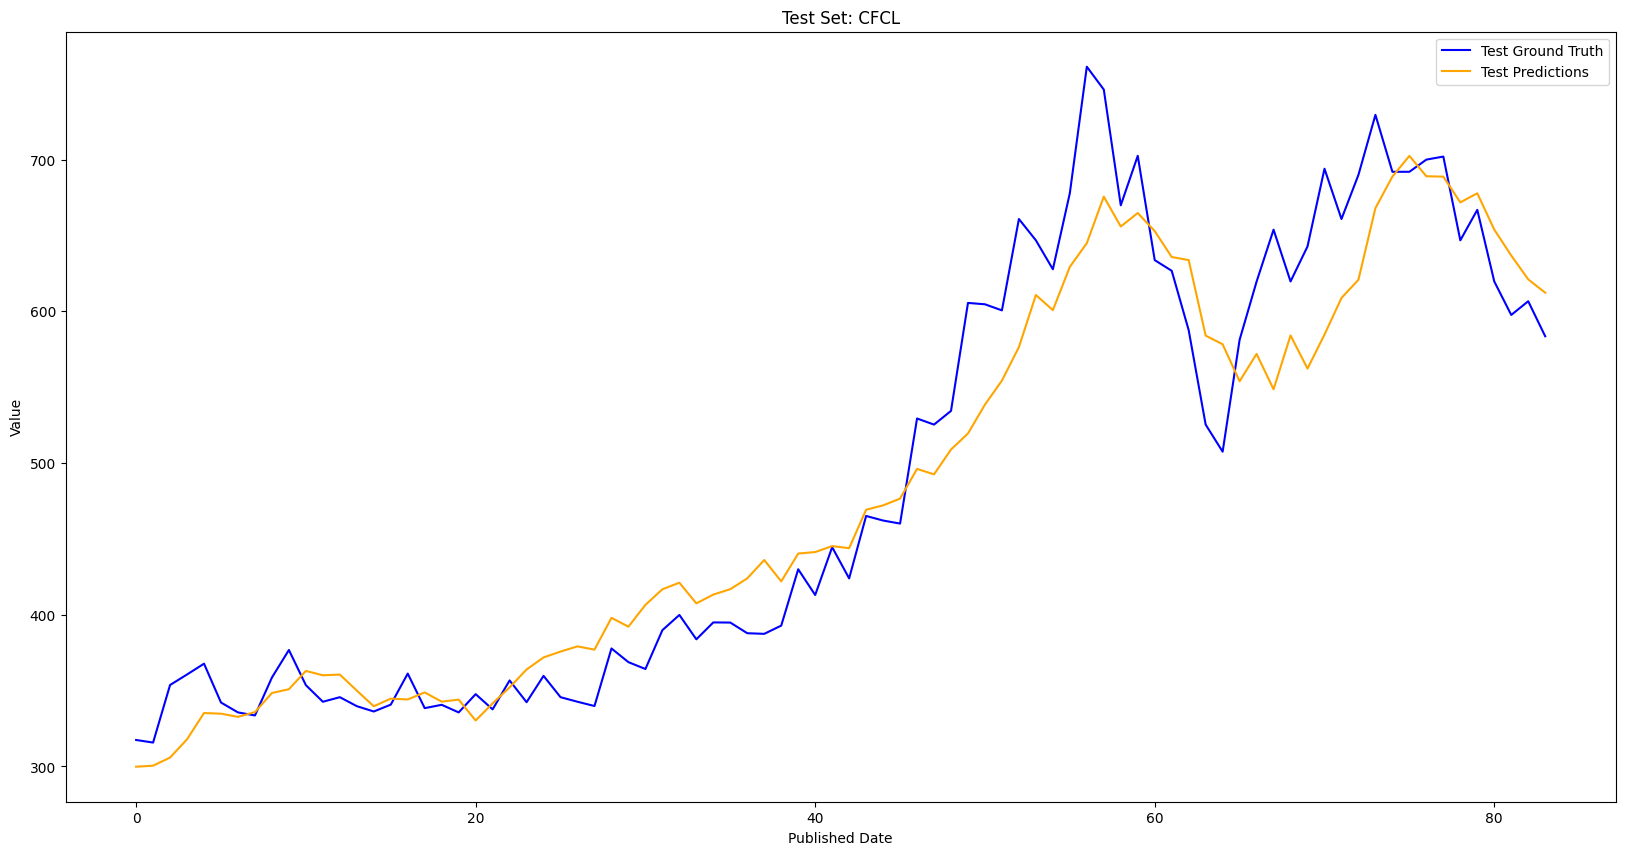

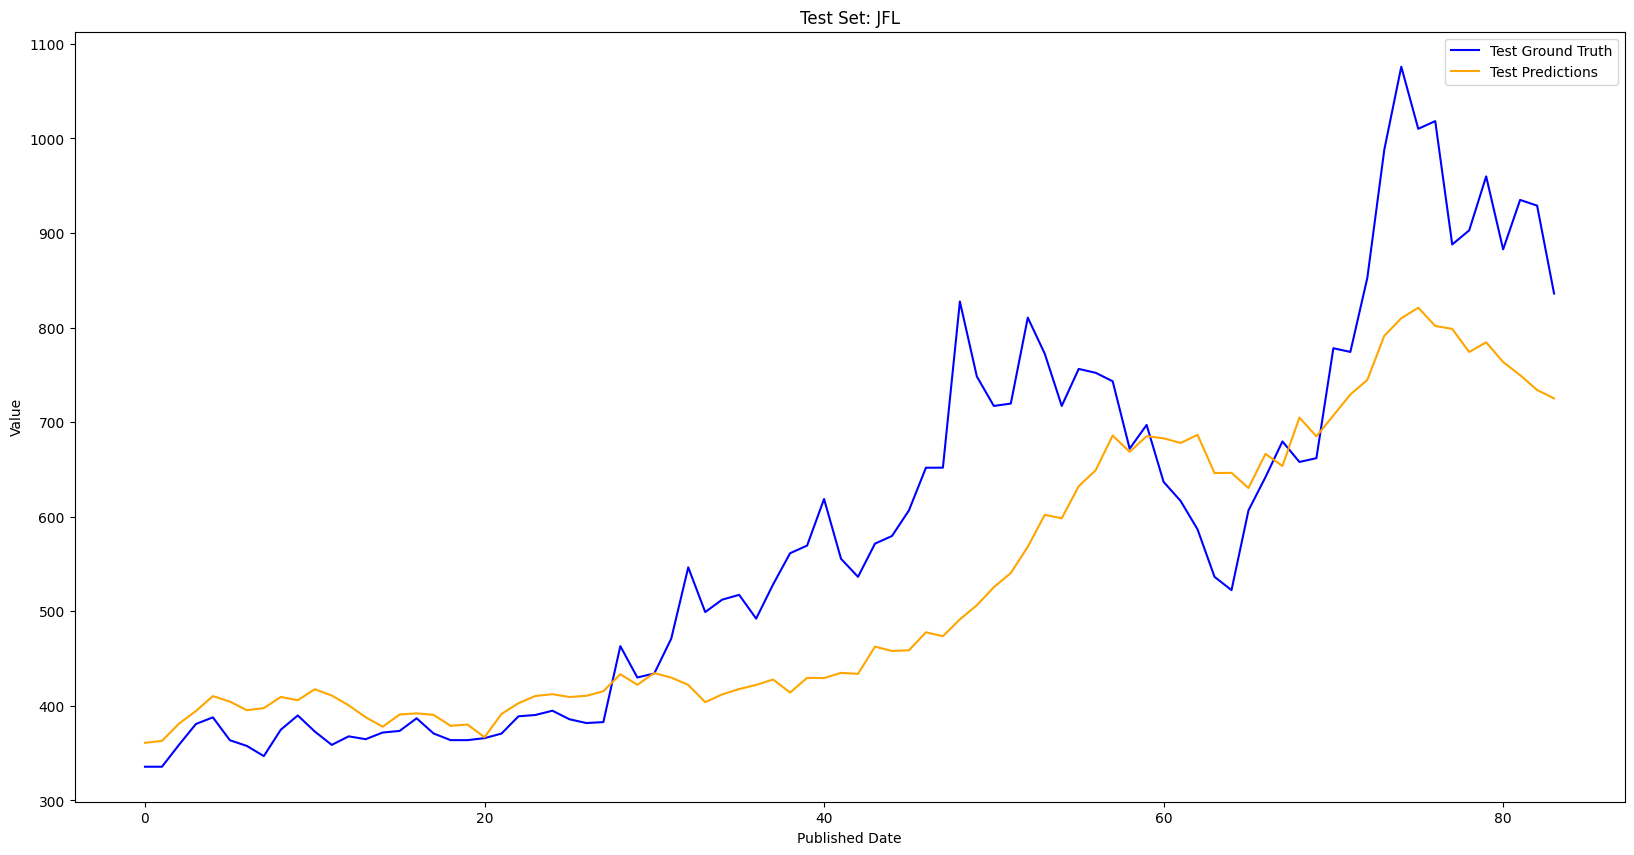

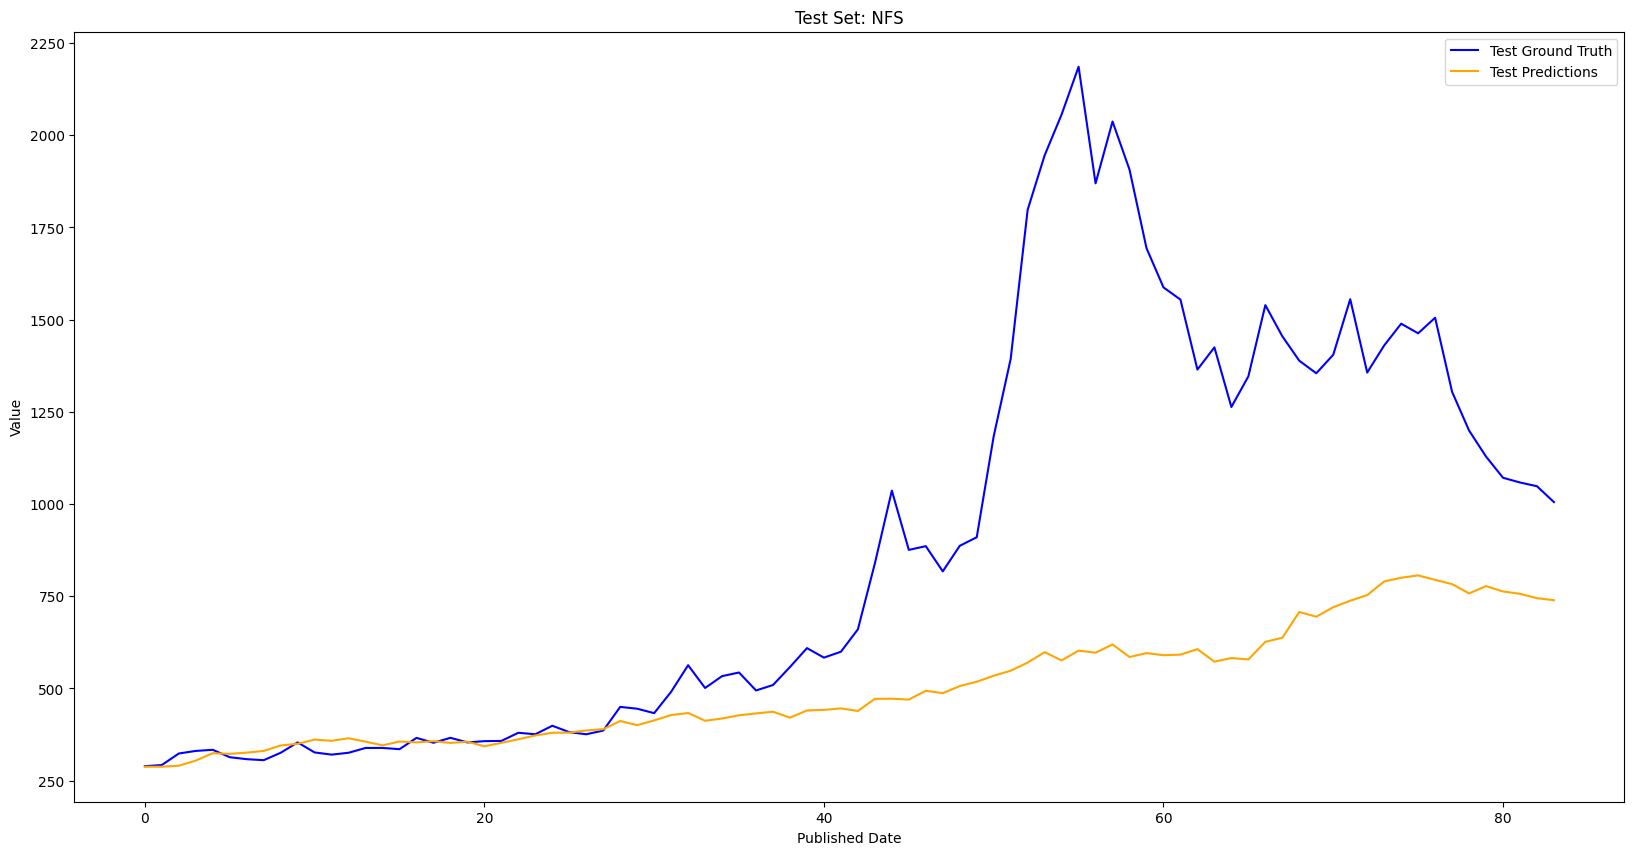

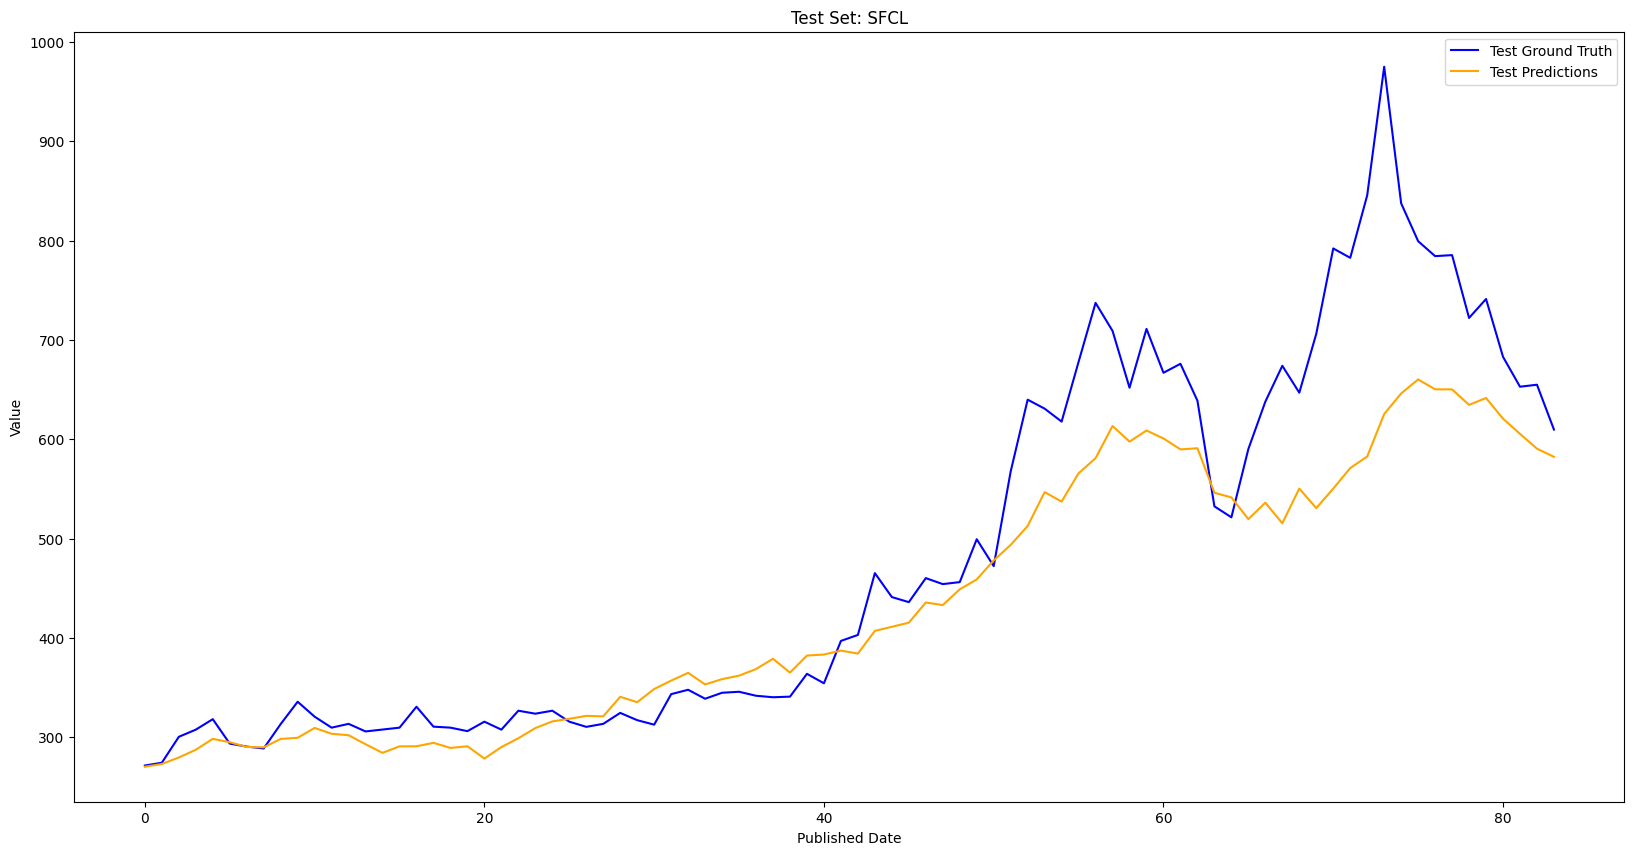

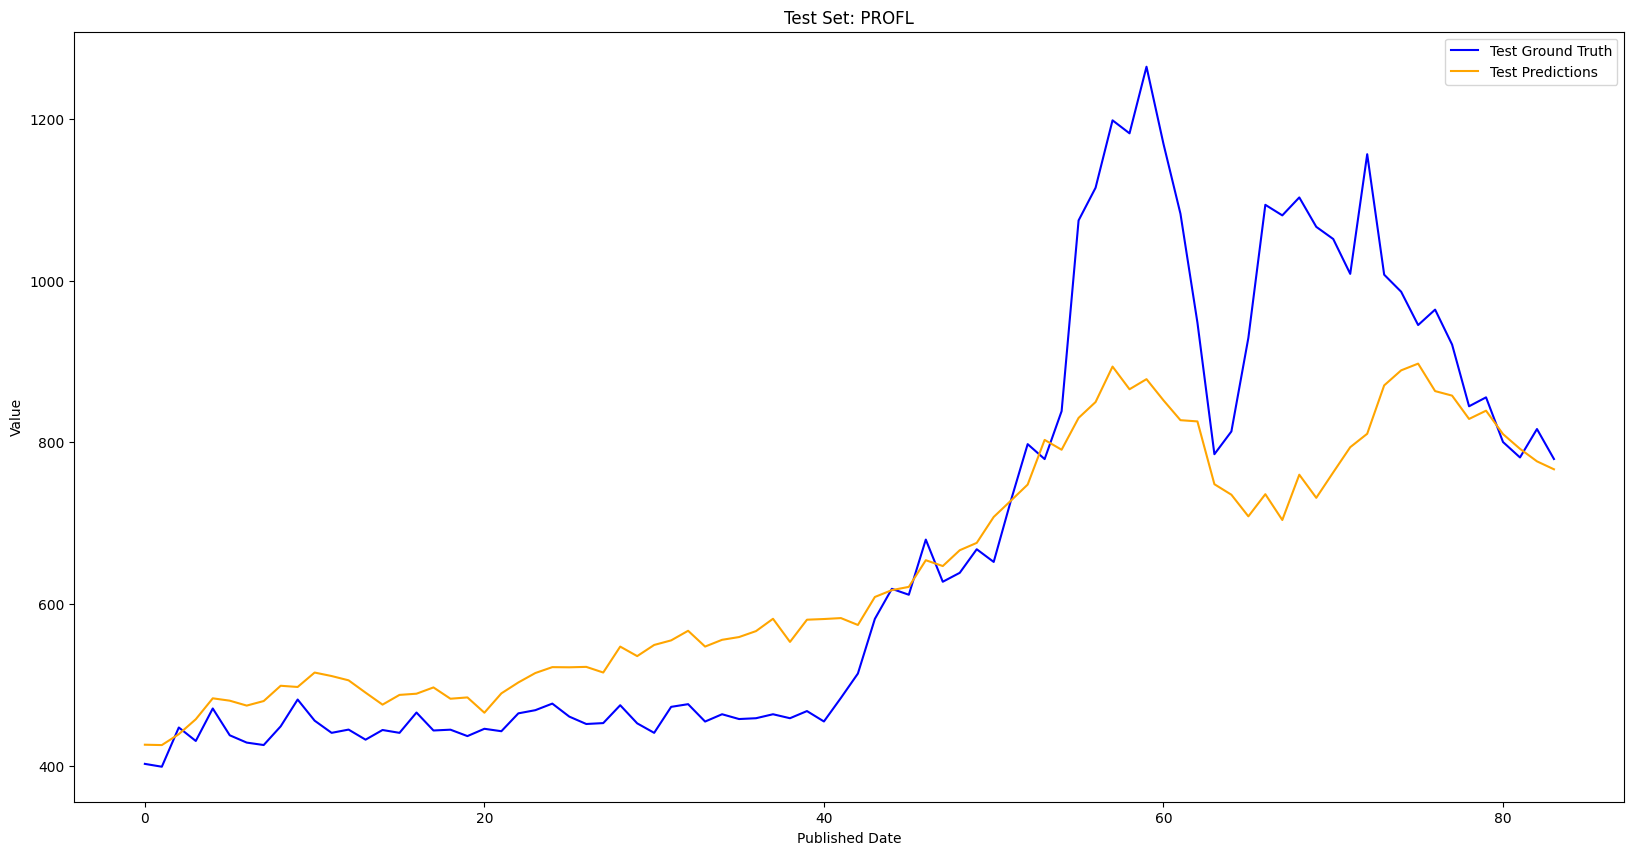

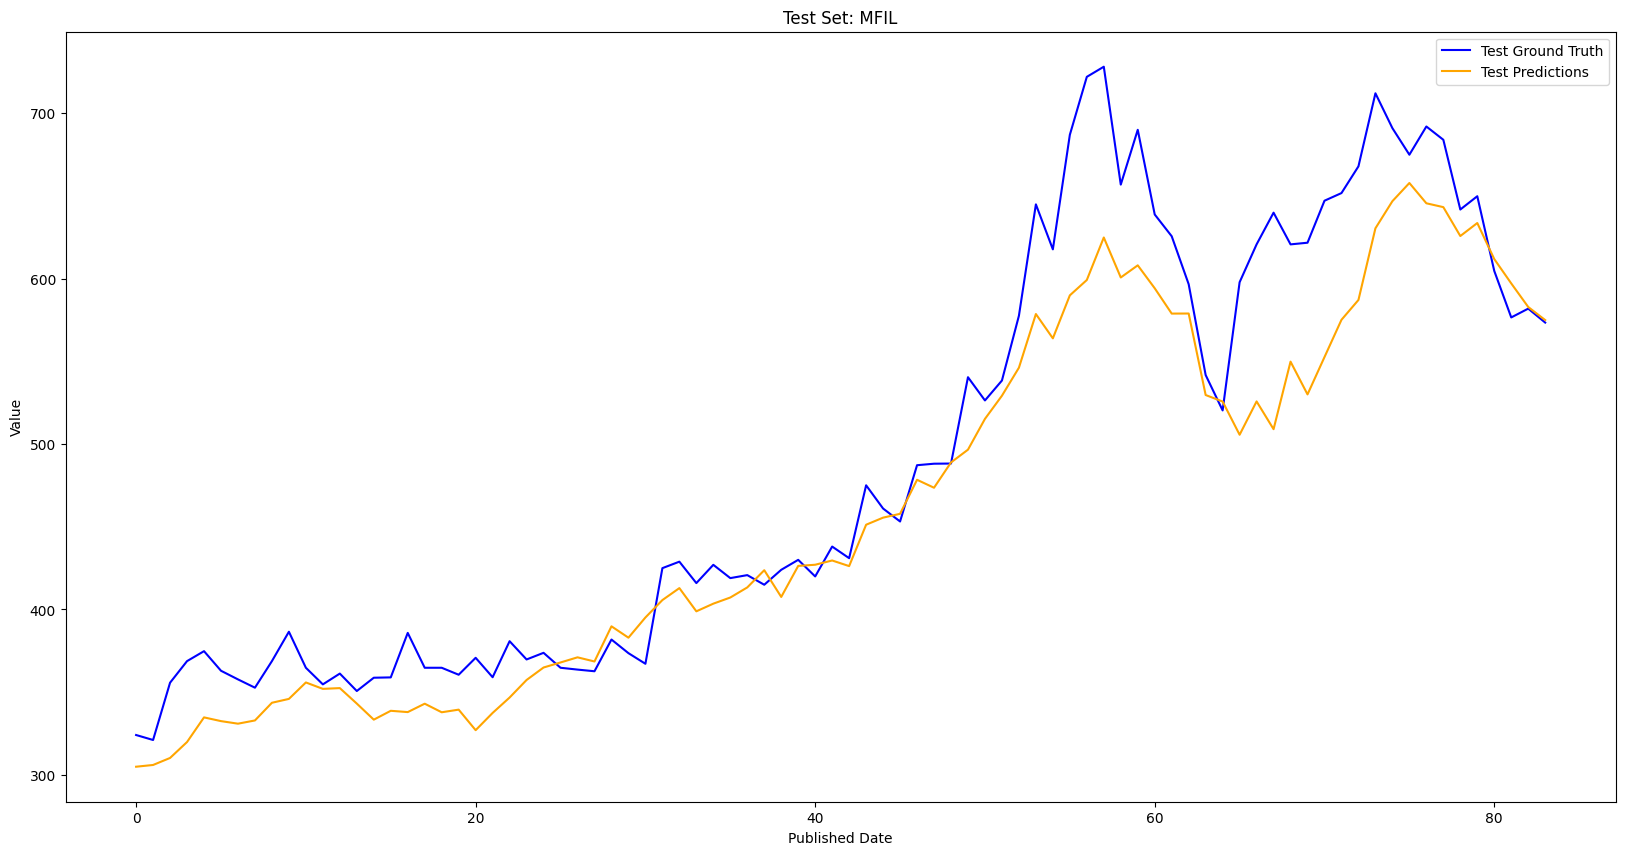

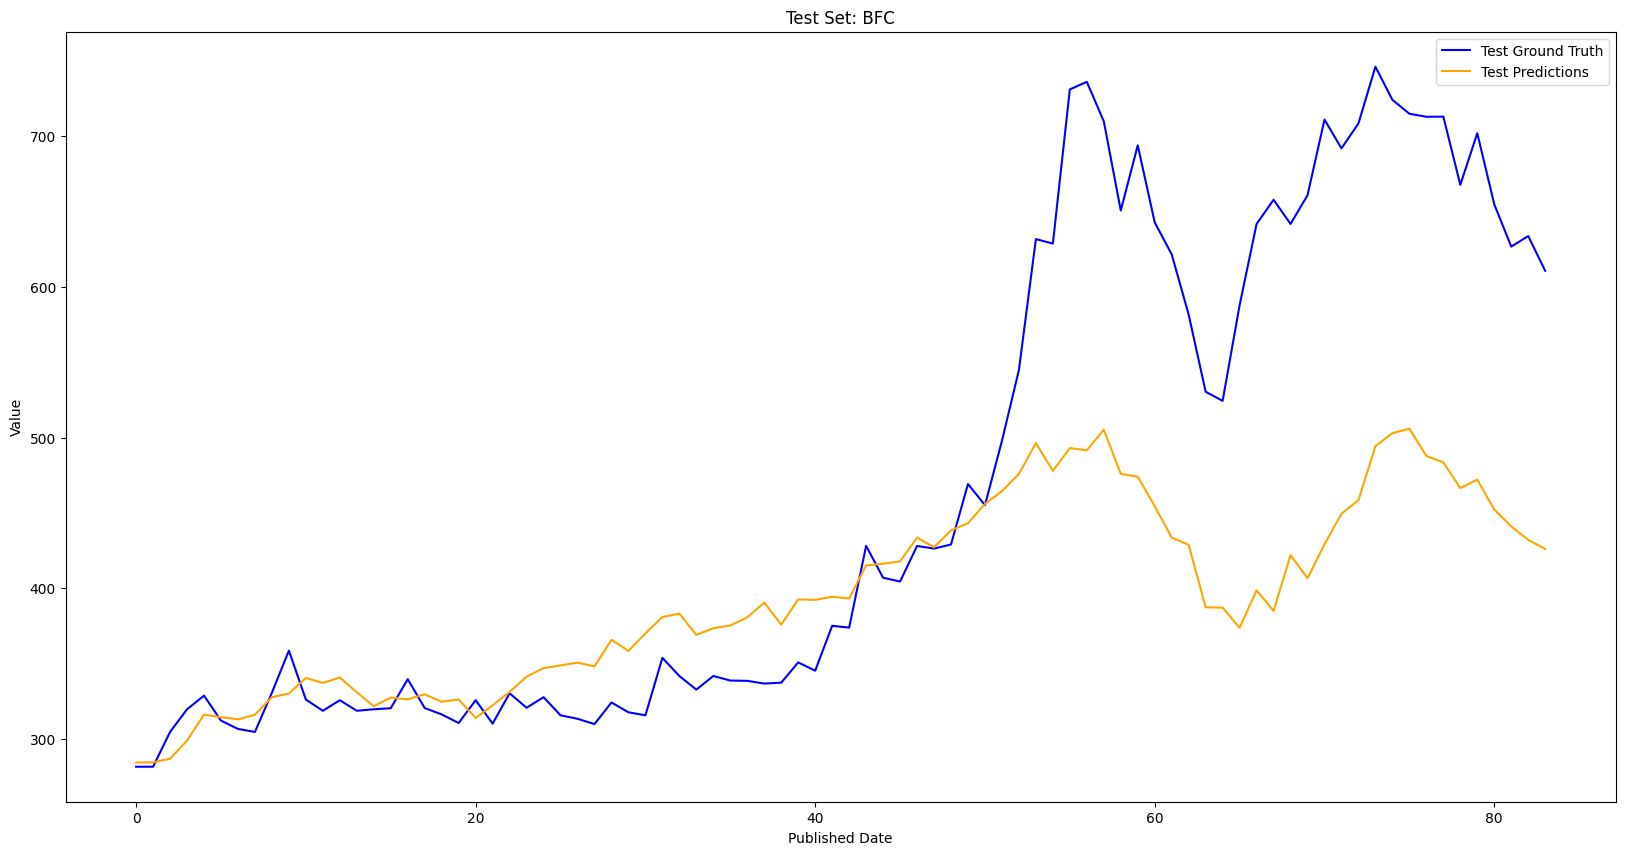

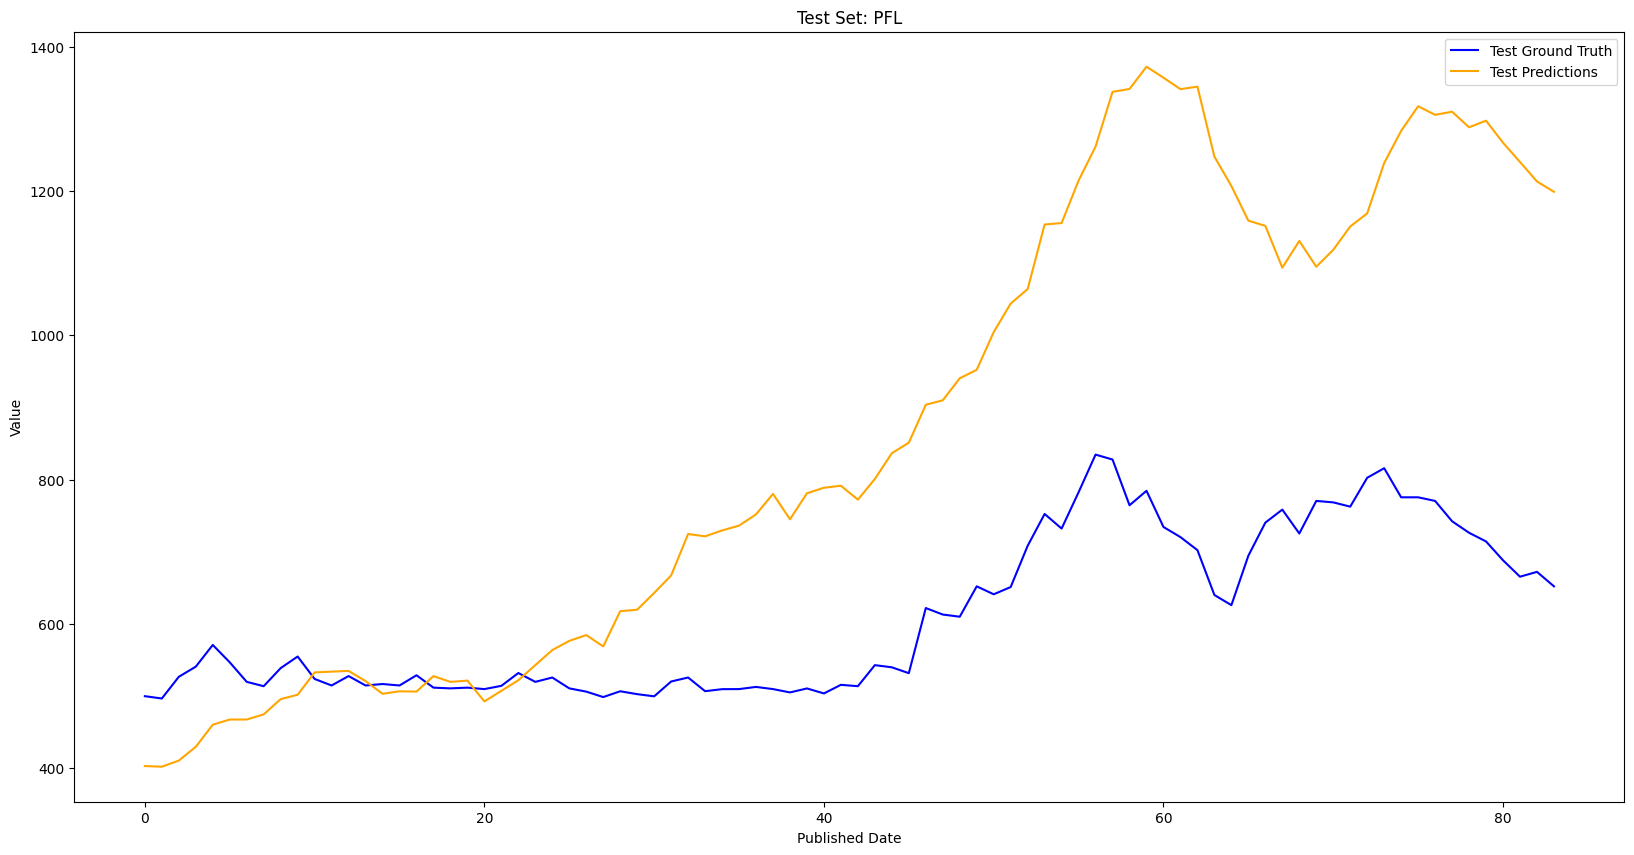

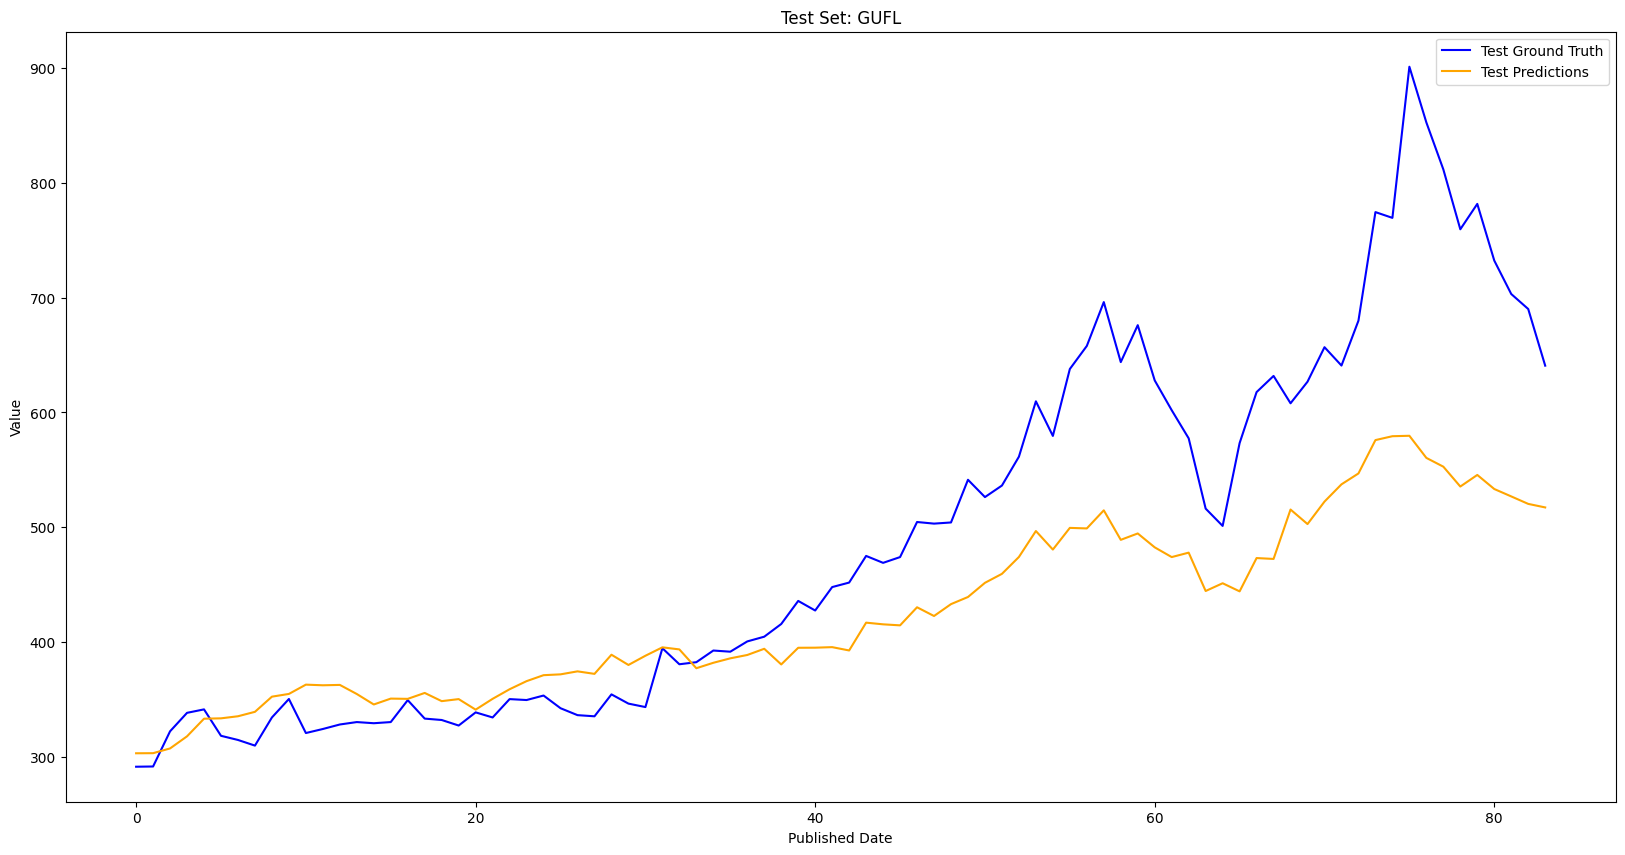

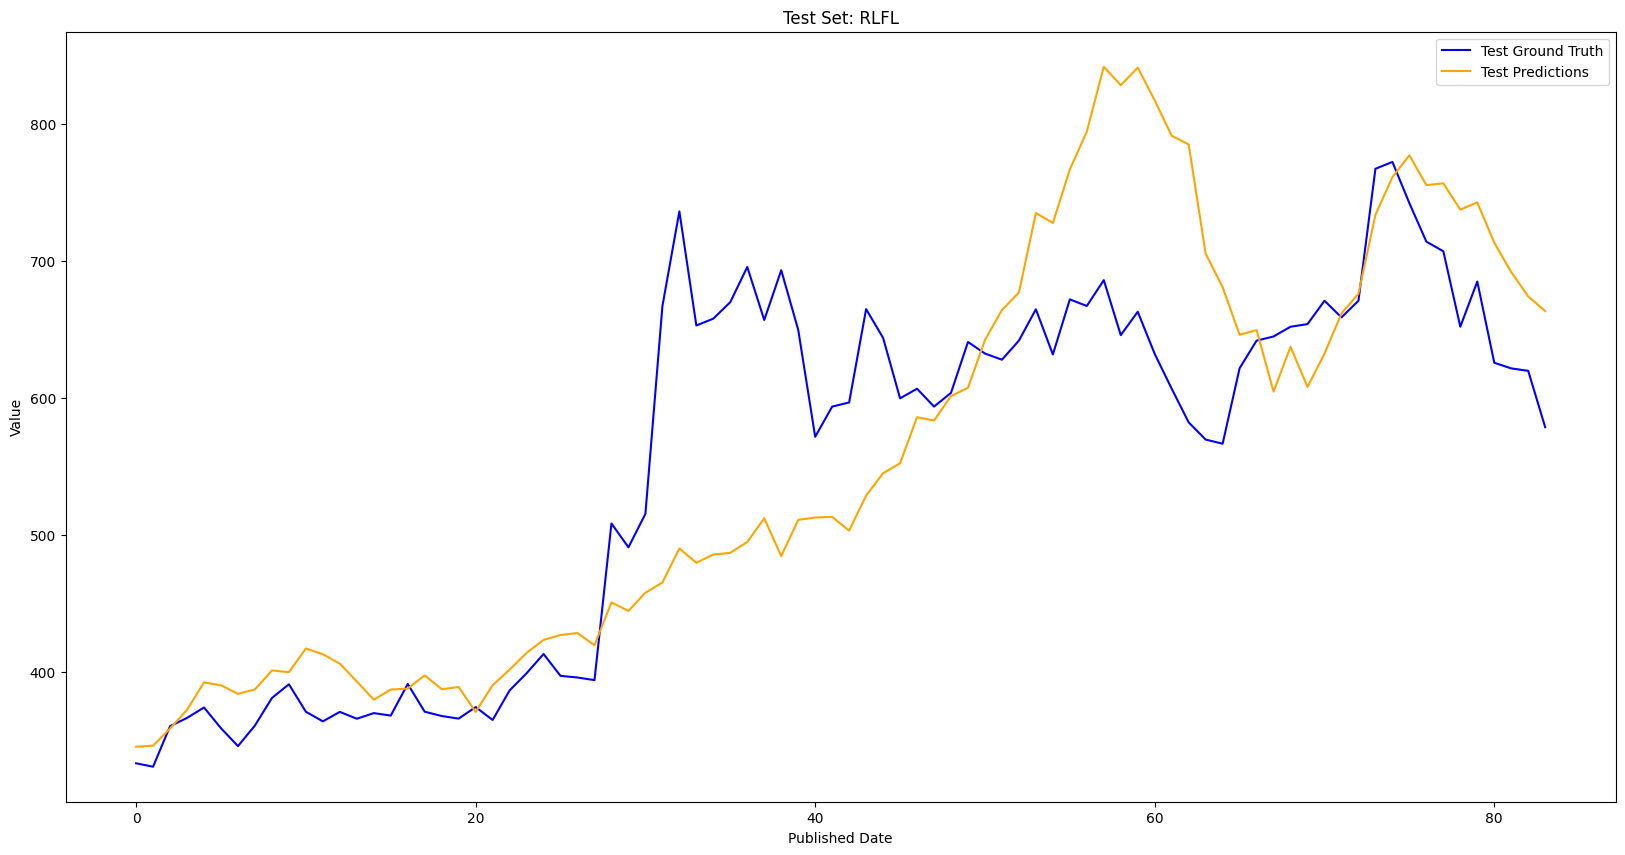

In [10]:
for i, col in enumerate(cols):
    plt.figure(figsize=(20, 10))
    sns.lineplot(data=test_ground_truth_df[i], x='published_date', y="Close", color="blue", label="Test Ground Truth")
    sns.lineplot(data=test_predictions_df[i], x='published_date', y="Close", color="orange", label="Test Predictions")
    plt.title(f"Test Set: {col}")
    plt.xlabel('Published Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()